In [1]:
from pymare import meta_regression
import pandas as pd
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import mapply
from scipy.stats import linregress
from sklearn.metrics import r2_score
from itertools import product
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [2]:
def scale(df):
    tmp = df.copy()
    tmp = (tmp - tmp.mean()) / tmp.std()
    return tmp

def fit_feature(y, x):
    idx = np.isfinite(x) #y should always be finite
    y = y[idx] 
    x = x[idx]
    s, i, r, p, serr = linregress(y, x)
    rabs = np.abs(r)
    x_cap = y * s + i
    r2 = r2_score(x, x_cap)
    rss = (np.square(x_cap - x)).sum()
    rse = np.sqrt(rss / (x.shape[0] - 2))
    return s, i, r, p, serr, rse, r2, rabs

# Gene expression meta

In [3]:
pdatas = [
          'data/gexp/geneMatTable_GSE30483_peripheral blood mononucleated cells collected from healthy controls.csv',
          'data/gexp/geneMatTable_GSE47353_day0+day70.csv',
          'data/gexp/geneMatTable_GSE68759_0WK+24WK.csv',
          'data/gexp/geneMatTable_GSE75511_PBMC.csv'
         ]
pmetas = [
          'data/gexp/ages_df_GSE30483_peripheral blood mononucleated cells collected from healthy controls.csv',
          'data/gexp/ages_df_GSE47353_day0+day70.csv',
          'data/gexp/ages_df_GSE68759_0WK+24WK.csv',
          'data/gexp/ages_df_GSE75511_PBMC.csv'
         ]

gses = ['GSE30483', 'GSE47353', 'GSE68759', 'GSE75511']

In [12]:
age_groups = ['0-20', '20-37', '37-60', '60-120']
sex_groups = ['M', 'F']
combs = list(product(age_groups, sex_groups))

design = pd.DataFrame({'age_group':[], 'sex':[], 'gse':[]})
regressions = []
for gse, d_path, p_path in zip(gses, pdatas, pmetas):
    #load
    df = pd.read_csv(d_path, index_col=0)
    pheno = pd.read_csv(p_path, index_col=1)
    #normalization
    df_scaled = np.log2(df + 1.0)
    df_scaled_normed = scale(df_scaled.T).T
    X_full = df_scaled_normed.T

    for ag, sx in combs:
        ag_min, ag_max = list(map(int, ag.split('-')))
        sub_idx = pheno[(pheno['ages'] >= ag_min) & 
                        (pheno['ages'] < ag_max) & 
                        (pheno['sex'] == sx)].index
        if len(sub_idx) < 3:
            print('Not enough samples. Skip!', gse, ag, sx)
            continue
        else:
            X = X_full.loc[sub_idx]
            y = pheno.loc[sub_idx]['ages']
            if y.unique().shape[0] < 2:
                print('Not enough different ages. Skip!', gse, ag, sx)
                continue

            #train all estimators
            mapply.init(n_workers=8, 
                        chunk_size=100, 
                        max_chunks_per_worker=10, 
                        progressbar=False)
            regres = X.mapply(lambda x: fit_feature(y, x), result_type='expand').rename(
                        index={ 0: 'slope', 
                                1: 'intercept', 
                                2: 'rvalue', 
                                3: 'p-value', 
                                4: 'stderr', 
                                5: 'rse',
                                6: 'r2',
                                7: 'rabs'}).T.sort_values('rabs', ascending=False)
            regressions.append(regres)
            design = design.append({'age_group':ag, 
                                    'sex':sx,
                                    'gse':gse}, ignore_index=True)


Not enough samples. Skip! GSE30483 0-20 M
Not enough samples. Skip! GSE30483 0-20 F
Not enough samples. Skip! GSE30483 60-120 F
Not enough samples. Skip! GSE47353 0-20 M
Not enough samples. Skip! GSE47353 0-20 F
Not enough samples. Skip! GSE47353 60-120 M
Not enough samples. Skip! GSE47353 60-120 F
Not enough samples. Skip! GSE68759 0-20 M
Not enough samples. Skip! GSE68759 0-20 F
Not enough samples. Skip! GSE68759 20-37 M
Not enough samples. Skip! GSE68759 20-37 F
Not enough different ages. Skip! GSE75511 0-20 M
Not enough samples. Skip! GSE75511 0-20 F
Not enough samples. Skip! GSE75511 60-120 M


In [13]:
#stable
from itertools import chain
entries = list(chain.from_iterable([r.index.tolist() for r in regressions]))

vals, counts = np.unique(entries, return_counts=True)
gcount = pd.DataFrame(counts, vals, columns=['counts']).sort_values('counts')
accepted_genes = gcount[gcount['counts'] >= 18].index #more than 6 entries of a gene

In [14]:
design_onehot = pd.get_dummies(design[['age_group', 'sex']])
design_onehot = design_onehot.drop(['age_group_20-37', 'sex_M'], axis=1)

In [16]:
#base level: age_20-37, M
metreg_results = pd.DataFrame()
for g in tqdm(accepted_genes):
    vals = [r.loc[g, 'slope'] for r in regressions]
    vars = [r.loc[g, 'stderr']**2 for r in regressions]
    #meta regression
    try:
        metreg = meta_regression(vals, vars, design_onehot, method='ML')
    except:
        continue
    mdf = metreg.to_df()
    mdf = mdf.set_index('name')[['estimate', 'p-value']].melt(ignore_index=False).reset_index()
    mdf['col'] = mdf['name'] + '_' + mdf['variable']
    mdf = mdf.drop(['name', 'variable'], axis=1)[['col', 'value']].set_index('col')
    mdf.columns = [g]
    metreg_results = pd.concat([metreg_results, mdf.T])
    

100%|██████████| 14963/14963 [02:29<00:00, 99.96it/s] 


In [17]:
#sns.scatterplot(pheno['ages'], df.loc['SALL3'], hue=pheno['sex'])

In [18]:
metreg_results.sort_values('intercept_p-value').to_csv('results/metreg.csv')

In [90]:
metreg_results.sort_values('age_group_37-60_estimate', ascending=False)[['age_group_37-60_estimate']].to_csv('results/rank37.rnk', sep='\t')

In [91]:
metreg_results.sort_values('intercept_estimate', ascending=False)[['intercept_estimate']].to_csv('results/rank_int.rnk', sep='\t')

In [73]:
sgn = metreg_results[metreg_results['intercept_p-value'] < 0.05]

In [79]:
pd.DataFrame(index=sgn.sort_values('intercept_p-value').index).to_csv('results/ref_list.csv')

In [60]:
sgn.sort_values('intercept_estimate')

col,intercept_estimate,age_group_37-60_estimate,age_group_60-120_estimate,sex_F_estimate,intercept_p-value,age_group_37-60_p-value,age_group_60-120_p-value,sex_F_p-value
NRCAM,-0.105255,0.017710,0.043282,0.045749,1.372222e-08,0.338970,0.246501,0.005420
NSMCE2,-0.098256,0.050299,0.022388,0.029516,1.940224e-04,0.065628,0.658897,0.232468
POLR3C,-0.096651,0.074675,-0.036195,0.026695,6.634355e-05,0.002549,0.413880,0.197609
PTRH2,-0.096503,0.052168,0.075655,0.052384,2.428382e-04,0.068447,0.036382,0.027608
NOLC1,-0.095230,0.063410,-0.056640,0.027148,3.820624e-05,0.008950,0.129669,0.206743
...,...,...,...,...,...,...,...,...
PLCD3,0.116396,-0.018289,0.008792,-0.108948,3.360740e-04,0.597601,0.870784,0.000531
TEPP,0.120783,-0.069756,0.020806,-0.071473,8.483811e-06,0.018077,0.790975,0.011727
IL17C,0.122845,-0.047060,0.186185,-0.104592,5.976803e-05,0.158198,0.000430,0.000705
IGFBP2,0.127419,-0.047078,0.025148,-0.097255,3.714091e-03,0.332780,0.708811,0.026768


In [61]:
sgn1 = sgn[sgn['age_group_37-60_p-value'] < 0.01]

In [57]:
sgn1.sort_values('intercept_estimate').to_csv('results/metareg_37.csv')

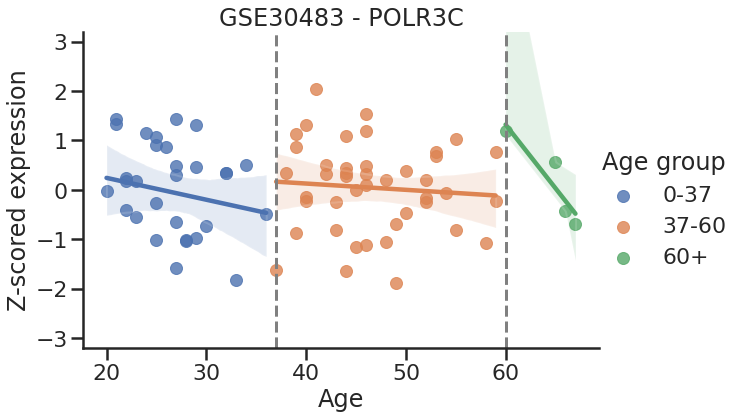

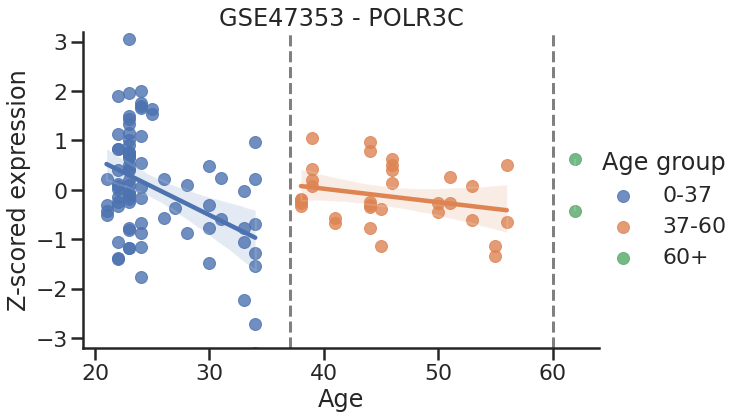

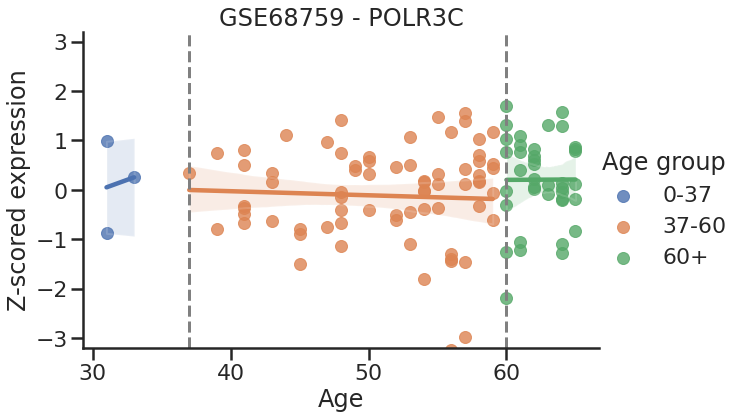

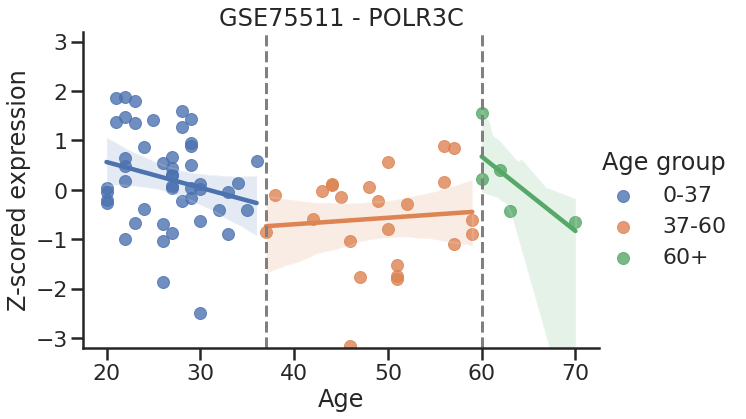

In [56]:
sns.set_theme(context='poster', style='ticks')
agegrf = lambda x: '0-20' if 0<=x<20 else '0-37' if 20<=x<37 else '37-60' if 37<=x<60 else '60+'

g = 'POLR3C'
for gse, d_path, p_path in zip(gses, pdatas, pmetas):
    #load
    df = pd.read_csv(d_path, index_col=0)
    pheno = pd.read_csv(p_path, index_col=1)
    pheno['Age group'] = pheno['ages'].apply(agegrf)
    #normalization
    df_scaled = np.log2(df + 1.0)
    df_scaled_normed = scale(df_scaled.T).T
    X_full = df_scaled_normed.T
    #filtering
    pheno['Expression'] = X_full[g]
    idx = pheno[pheno['ages'] >= 20].index
    pheno = pheno.loc[idx]
    
    gr = sns.lmplot(data=pheno, x='ages', y='Expression', hue='Age group', 
                    hue_order=['0-37', '37-60', '60+'],
                    height=6, aspect=1.5)
    plt.axvline(37, color='grey', ls='--')
    plt.axvline(60, color='grey', ls='--')
    plt.title(f'{gse} - {g}')
    plt.ylabel('Z-scored expression')
    plt.xlabel('Age')
    
    plt.ylim([-3.2, 3.2])
    plt.show()

# DNA Methylation meta

In [93]:
import pyreadr

D = pyreadr.read_r('data/Reduct_CpG.RData')

In [94]:
D.keys()

odict_keys(['CpG2_1', 'CpG2_2', 'Anatation_Gene_CpG2_1', 'Anatation_Gene_CpG2_2', 'sampleTable'])

In [150]:
sampletable = D['sampleTable']
data = D['CpG2_2']
data.columns = sampletable.index
print(len(sampletable))

3561


In [151]:
for e in sampletable['Exp'].unique():
    idx = sampletable[sampletable['Exp'] == e].index
    data[idx].to_csv(f'data/meth/{e}_data_2.csv')
    sampletable.loc[idx].to_csv(f'data/meth/{e}_pheno_2.csv')

In [149]:
gses = ['GSE557663', 'GSE40279', 'GSE152027']

In [184]:
age_groups = ['0-37', '37-60', '60-120']
sex_groups = ['M', 'F']
combs = list(product(age_groups, sex_groups))

design = pd.DataFrame({'age_group':[], 'sex':[], 'gse':[]})
regressions = []
for gse in gses:
    #load
    df = pd.read_csv(f'data/meth/{gse}_data_2.csv', index_col=0)
    pheno = pd.read_csv(f'data/meth/{gse}_pheno_2.csv', index_col=0)
    #normalization
    df_scaled_normed = scale(df.T).T
    X_full = df_scaled_normed.T

    for ag, sx in combs:
        ag_min, ag_max = list(map(int, ag.split('-')))
        sub_idx = pheno[(pheno['age'] >= ag_min) & 
                        (pheno['age'] < ag_max) & 
                        (pheno['gender'] == sx)].index
        if len(sub_idx) < 3:
            print('Not enough samples. Skip!', gse, ag, sx)
            continue
        else:
            X = X_full.loc[sub_idx]
            y = pheno.loc[sub_idx]['age']
            if y.unique().shape[0] < 2:
                print('Not enough different ages. Skip!', gse, ag, sx)
                continue

            #train all estimators
            mapply.init(n_workers=8, 
                        chunk_size=100, 
                        max_chunks_per_worker=10, 
                        progressbar=False)
            regres = X.mapply(lambda x: fit_feature(y, x), result_type='expand').rename(
                        index={ 0: 'slope', 
                                1: 'intercept', 
                                2: 'rvalue', 
                                3: 'p-value', 
                                4: 'stderr', 
                                5: 'rse',
                                6: 'r2',
                                7: 'rabs'}).T.sort_values('rabs', ascending=False)
            regressions.append(regres)
            design = design.append({'age_group':ag, 
                                    'sex':sx,
                                    'gse':gse}, ignore_index=True)


Not enough samples. Skip! GSE152027 60-120 M
Not enough samples. Skip! GSE152027 60-120 F


In [185]:
#stable
from itertools import chain
entries = list(chain.from_iterable([r.index.tolist() for r in regressions]))

vals, counts = np.unique(entries, return_counts=True)
gcount = pd.DataFrame(counts, vals, columns=['counts']).sort_values('counts')
accepted_genes = gcount[gcount['counts'] >= 3].index #more than 6 entries of a gene

In [186]:
design_onehot = pd.get_dummies(design[['age_group', 'sex']])
design_onehot = design_onehot.drop(['age_group_0-37', 'sex_M'], axis=1)

In [187]:
#base level: age_20-37, M
metreg_results = pd.DataFrame()
for g in tqdm(accepted_genes):
    vals = [r.loc[g, 'slope'] for r in regressions]
    vars = [r.loc[g, 'stderr']**2 for r in regressions]
    #meta regression
    try:
        metreg = meta_regression(vals, vars, design_onehot, method='ML')
    except:
        continue
    mdf = metreg.to_df()
    mdf = mdf.set_index('name')[['estimate', 'p-value']].melt(ignore_index=False).reset_index()
    mdf['col'] = mdf['name'] + '_' + mdf['variable']
    mdf = mdf.drop(['name', 'variable'], axis=1)[['col', 'value']].set_index('col')
    mdf.columns = [g]
    metreg_results = pd.concat([metreg_results, mdf.T])

100%|██████████| 56/56 [00:00<00:00, 83.35it/s]


In [188]:
metreg_results.sort_values('intercept_p-value')

col,intercept_estimate,age_group_37-60_estimate,age_group_60-120_estimate,sex_F_estimate,intercept_p-value,age_group_37-60_p-value,age_group_60-120_p-value,sex_F_p-value
cg07558287,0.028151,0.002982,0.026916,-0.006055,0.003970,0.760645,0.009739,0.245193
cg23785719,-0.041061,0.033029,0.050946,0.007615,0.010518,0.050724,0.003063,0.425787
cg09070492,-0.028522,0.034342,0.044269,-0.001674,0.032417,0.010830,0.001549,0.772801
cg26147935,-0.028091,0.012522,0.044195,-0.003017,0.051272,0.393103,0.003439,0.597290
cg10241697,0.035018,-0.024860,-0.027704,0.006416,0.053253,0.206790,0.165583,0.613928
cg23350904,0.026006,-0.014083,-0.035887,0.003691,0.073677,0.355641,0.021166,0.674285
cg23090824,0.024821,-0.016131,-0.037654,0.010171,0.074524,0.250323,0.009173,0.113623
cg02758053,0.025259,-0.029485,0.001520,-0.012961,0.079698,0.044061,0.919512,0.023366
cg24363298,0.025611,-0.029550,-0.001368,-0.014258,0.092893,0.055251,0.930950,0.014433
cg08886823,0.023420,-0.005469,-0.029542,0.010443,0.106342,0.715585,0.055501,0.169429


In [189]:
sgn = metreg_results[metreg_results['intercept_p-value'] < 0.05]

In [190]:
sgn

col,intercept_estimate,age_group_37-60_estimate,age_group_60-120_estimate,sex_F_estimate,intercept_p-value,age_group_37-60_p-value,age_group_60-120_p-value,sex_F_p-value
cg23785719,-0.041061,0.033029,0.050946,0.007615,0.010518,0.050724,0.003063,0.425787
cg07558287,0.028151,0.002982,0.026916,-0.006055,0.003970,0.760645,0.009739,0.245193
cg09070492,-0.028522,0.034342,0.044269,-0.001674,0.032417,0.010830,0.001549,0.772801


In [191]:
sgn1 = sgn[sgn['age_group_37-60_p-value'] < 0.05]

In [192]:
sgn1

col,intercept_estimate,age_group_37-60_estimate,age_group_60-120_estimate,sex_F_estimate,intercept_p-value,age_group_37-60_p-value,age_group_60-120_p-value,sex_F_p-value
cg09070492,-0.028522,0.034342,0.044269,-0.001674,0.032417,0.01083,0.001549,0.772801


In [193]:
sgn1.to_csv('results/metareg_meth_37_2.csv')